In [1]:
!pip install finterstellar

In [2]:
# Import library
import finterstellar as fs
#System trading Library 설치: Finterstellar

import io, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
symbol_ = 'TSLA'
start_date_ = '2020-06-30'
end_date_ = '2025-06-30'
fee_ = 0.001

In [20]:
import os

path_list = ["rsi","macd","stochastic"]

for path in path_list :
    try:
        os.makedirs(path, exist_ok=True)
        print(f"{path} 디렉토리가 생성되었거나 이미 존재합니다.")
    except OSError as e:
        print(f"디렉토리 생성 중 오류 발생: {e}")


rsi 디렉토리가 생성되었거나 이미 존재합니다.
macd 디렉토리가 생성되었거나 이미 존재합니다.
stochastic 디렉토리가 생성되었거나 이미 존재합니다.


In [4]:
# 1. RSI Performance and evaluation

In [5]:
# finstaller.performance 를 dict 로 반환하는 함수

import re

def parse_performance_output(output_text):
    result = {}
    for line in output_text.strip().split("\n"):
        # 콜론으로 분리
        if ":" not in line:
            continue
        key, value = line.split(":", 1)
        key = key.strip()
        value = value.strip()

        # 퍼센트 처리
        if value.endswith("%"):
            num = float(value.strip("%")) / 100
            result[key] = num
        # 연도 처리
        elif value.endswith("yrs"):
            num = float(value.strip("yrs"))
            result[key] = num
        # 숫자 처리
        else:
            try:
                result[key] = float(value)
            except ValueError:
                result[key] = value  # 혹시 문자열이면 그대로 저장

    return result


def parse_performance_output(output_text, pre_text):
    result = {}
    for line in output_text.strip().split("\n"):
        # 콜론으로 분리
        if ":" not in line:
            continue
        key, value = line.split(":", 1)
        key = pre_text + "_" + key.strip()
        value = value.strip()

        # 퍼센트 처리
        if value.endswith("%"):
            num = float(value.strip("%")) / 100
            result[key] = num
        # 연도 처리
        elif value.endswith("yrs"):
            num = float(value.strip("yrs"))
            result[key] = num
        # 숫자 처리
        else:
            try:
                result[key] = float(value)
            except ValueError:
                result[key] = value  # 혹시 문자열이면 그대로 저장

    return result

In [6]:
# RSI 함수 정의
def get_rsi_performance(df, w_, buy_, sell_, fee) :
    fs.rsi(df, w=w_)
    fs.indicator_to_signal(df, factor='rsi', buy=buy_, sell=sell_)
    fs.position(df)
    fs.evaluate(df, cost= fee)

    # print 값 변수화
    capture = io.StringIO()
    # stdout 백업
    old_stdout = sys.stdout

    try:
        # stdout을 StringIO로 바꿈
        sys.stdout = capture

        # 함수 실행 (print만 함)
        fs.performance(df, rf_rate=0.02)

    finally:
        # stdout 복원
        sys.stdout = old_stdout

    # 캡처된 텍스트
    output_text = capture.getvalue()
    # performance dict 화
    # performance_dict = parse_performance_output(output_text)
    performance_dict = parse_performance_output(output_text, 'RSI')

    return performance_dict

In [7]:
# MACD 함수 정의
def get_macd_performance(df, buy_, sell_, fee) :
    fs.macd(df)
    fs.indicator_to_signal(df, factor='macd', buy=buy_, sell=sell_)
    fs.position(df)
    fs.evaluate(df, cost= fee)

    # print 값 변수화
    capture = io.StringIO()
    # stdout 백업
    old_stdout = sys.stdout

    try:
        # stdout을 StringIO로 바꿈
        sys.stdout = capture

        # 함수 실행 (print만 함)
        fs.performance(df, rf_rate=0.02)

    finally:
        # stdout 복원
        sys.stdout = old_stdout

    # 캡처된 텍스트
    output_text = capture.getvalue()
    # performance dict 화
    # performance_dict = parse_performance_output(output_text)
    performance_dict = parse_performance_output(output_text, 'MACD')

    return performance_dict

In [8]:
# Stochastics 함수 정의
# Stochastics 함수는 w_.값에 factor ('slow_k', 'indicator') 값을 이용한다
def get_stochastics_performance(symbol, df, factor_, buy_, sell_, fee_) :
    fs.stochastic(df, symbol, n=14, m=3, t=3)
    # indicator 값 추출을 위한 전처리 작업
    df['indicator'] = df['slow_k'] - df['slow_d']

    fs.indicator_to_signal(df, factor= factor_, buy=buy_, sell=sell_)
    fs.position(df)
    fs.evaluate(df, cost= fee_)

    # print 값 변수화
    capture = io.StringIO()
    # stdout 백업
    old_stdout = sys.stdout

    try:
        # stdout을 StringIO로 바꿈
        sys.stdout = capture

        # 함수 실행 (print만 함)
        fs.performance(df, rf_rate=0.02)

    finally:
        # stdout 복원
        sys.stdout = old_stdout

    # 캡처된 텍스트
    output_text = capture.getvalue()
    # performance dict 화
    # performance_dict = parse_performance_output(output_text)
    performance_dict = parse_performance_output(output_text, 'Stochastics')

    return performance_dict

In [9]:
# 기본 팩터자료 함수 정의
# symbol : 주식 약칭명
# start_date_ : 시작일자, end_date_ : 종료일자
# fee_ : 거래수수료
def get_rsi_performance_dataframe(symbol, start_date_, end_date_, fee_) :
    df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)
    print(f"[ {symbol} ] dataFrame.head ")
    print(df.head(3))

    results = []
    # 최적의 w, buy_position, sell_position 을 찾기 위한 recursive
    for w_ in range(7, 23+1) :
        for buy_ in range(15, 45+1) :
            for sell_ in range(55, 85+1) :
                try :
                    result_dict = {}

                    # 파라미터 추가
                    result_dict["symbol"] = symbol
                    result_dict["w_param"] = w_
                    result_dict["buy_param"] = buy_
                    result_dict["sell_param"] = sell_

                    perf = {}

                    perf = get_rsi_performance(df, w_, buy_, sell_, fee_)

                    result_dict.update(perf)

                    # 리스트에 추가
                    results.append(result_dict)

                    if(len(results) % 1000 == 0) :
                        print(f"Performance Processing : [{len(results)}] {result_dict}")
                except Exception as e :
                    print(" !!! Error : ",e)
                    continue

    df_result = pd.DataFrame(results)
    return df_result


In [10]:
# 기본 팩터자료 함수 정의
# symbol : 주식 약칭명
# start_date_ : 시작일자, end_date_ : 종료일자
# fee_ : 거래수수료
def get_macd_performance_dataframe(symbol, start_date_, end_date_, fee_) :
    df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)
    print(f"[ {symbol} ] dataFrame.head ")
    print(df.head(3))

    results = []
    # 최적의 buy_position, sell_position 을 찾기 위한 recursive
    for buy_ in range(-10, 10+1) :
        for sell_ in range(-10, 10+1) :
            try :
                result_dict = {}

                # 파라미터 추가
                result_dict["symbol"] = symbol
                result_dict["buy_param"] = buy_
                result_dict["sell_param"] = sell_

                perf = {}

                perf = get_macd_performance(df, buy_, sell_, fee_)

                result_dict.update(perf)

                # 리스트에 추가
                results.append(result_dict)

                if(len(results) % 100 == 0) :
                    print(f"Performance Processing : [{len(results)}] {result_dict}")
            except Exception as e :
                print(" !!! Error : ",e)
                continue

    df_result = pd.DataFrame(results)
    return df_result


In [11]:
# 기본 팩터자료 함수 정의
# symbol : 주식 약칭명
# start_date_ : 시작일자, end_date_ : 종료일자
# fee_ : 거래수수료
def get_stochastic_performance_dataframe(symbol, start_date_, end_date_, fee_) :
    df = fs.get_ohlc(symbol, start_date=start_date_, end_date=end_date_)
    print(f"[ {symbol} ] dataFrame.head ")
    print(df.head(3))

    results = []
    # 최적의 buy_position, sell_position 을 찾기 위한 recursive
    # 1. slow_k
    for buy_ in range(10, 40+1) :
        for sell_ in range(60, 90+1) :
            try :
                result_dict = {}

                # 파라미터 추가
                result_dict["symbol"] = symbol
                result_dict["factor"] = "slow_k"
                result_dict["buy_param"] = buy_
                result_dict["sell_param"] = sell_

                perf = {}

                perf = get_stochastics_performance(symbol, df, "slow_k", buy_, sell_, fee_)

                result_dict.update(perf)

                # 리스트에 추가
                results.append(result_dict)
                if(len(results) % 500 == 0) :
                    print(f"Performance Processing : [{len(results)}] {result_dict}")
            except Exception as e :
                print(" !!! Error : ",e)
                continue


    # 2. indicator
    for buy_ in range(-10, 10+1) :
        for sell_ in range(-10, 10+1) :
            try :
                result_dict = {}

                # 파라미터 추가
                result_dict["symbol"] = symbol
                result_dict["factor"] = "indicator"
                result_dict["buy_param"] = buy_
                result_dict["sell_param"] = sell_

                perf = {}

                perf = get_stochastics_performance(symbol, df, "indicator", buy_, sell_, fee_)

                result_dict.update(perf)

                # 리스트에 추가
                results.append(result_dict)

                if(len(results) % 500 == 0) :
                    print(f"Performance Processing : [{len(results)}] {result_dict}")
            except Exception as e :
                print(" !!! Error : ",e)
                continue

    df_result = pd.DataFrame(results)

    return df_result


In [12]:
def get_rsi_algorithm_info(symbol, start_date_, end_date_, w_, buy_, sell_, text, fee_) :
    df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)

    # rsi
    fs.rsi(df, w=w_)
    fs.draw_chart(df, left='rsi', right= symbol)
    # 파일로 저장
    plt.savefig(f"./rsi//{symbol}_{text}_price_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    fs.indicator_to_signal(df, factor='rsi', buy=buy_, sell=sell_)
    # Calc position
    fs.position(df)
    fs.draw_chart(df, left='rsi', right='position_chart')
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_position_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    # Evalution
    fs.evaluate(df, cost= fee_)
    fs.draw_chart(df, left='acc_rtn_dp', right=symbol)
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_evaluation_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    # get Performance
    fs.performance(df, rf_rate=0.02)

    fs.draw_trade_results(df)
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_trade_result_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

In [13]:
def get_macd_algorithm_info(symbol, start_date_, end_date_, buy_, sell_,text,  fee_) :
    df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)

    # macd
    fs.macd(df)
    fs.draw_chart(df, right=['macd','macd_signal','macd_oscillator'])
    # 파일로 저장
    plt.savefig(f"./macd/{symbol}_{text}_price_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    fs.indicator_to_signal(df, factor='macd_oscillator', buy=buy_, sell=sell_)

    # Calc position
    fs.position(df)
    fs.draw_chart(df, right='position_chart', left='macd_oscillator')
    # 파일로 저장
    plt.savefig(f"./macd/{symbol}_{text}_position_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()


    # Evalution
    fs.evaluate(df, cost=fee_)
    fs.performance(df, rf_rate=0.02)
    fs.draw_trade_results(df)
    # 파일로 저장
    plt.savefig(f"./macd/{symbol}_{text}_trade_result_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

In [14]:
def get_stochastic_algorithm_info(symbol, start_date_, end_date_, factor_, buy_, sell_,text, fee_) :
    df = fs.get_ohlc(symbol, start_date=start_date_, end_date=end_date_)

    # stochastic
    fs.stochastic(df, symbol, n=14, m=3, t=3)
    df['indicator'] = df['slow_k'] - df['slow_d']
    fs.draw_chart(df, left=factor_, right=symbol)
    # 파일로 저장
    plt.savefig(f"./stochastic/{symbol}_{text}_price_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    fs.indicator_to_signal(df, factor=factor_, buy=buy_, sell=sell_)

    # Calc position
    fs.position(df)
    fs.draw_chart(df, right='position_chart', left='slow_k')
    # # 파일로 저장
    plt.savefig(f"./stochastic/{symbol}_{text}_position_chart.png", dpi=300, bbox_inches="tight")
    # # 리소스 해제
    # plt.close()


    # Evalution
    fs.evaluate(df, cost=fee_)
    fs.performance(df, rf_rate=0.02)
    fs.draw_trade_results(df)
    # 파일로 저장
    plt.savefig(f"./stochastic/{symbol}_{text}_trade_result_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

In [15]:
# # Max CAGR
# df_max_cagr = df_rsi[df_rsi['RSI_CAGR'] == df_rsi['RSI_CAGR'].max()]
# df_max_cagr.iloc[0]

In [ ]:
# # Max Sharpe ratio
# df_max_sharpe_ratio = df_rsi[df_rsi['RSI_Sharpe ratio'] == df_rsi['RSI_Sharpe ratio'].max()]
# df_max_sharpe_ratio.iloc[0]

In [ ]:
# get_rsi_algorithm_info(df_max_cagr.iloc[0]['symbol'],start_date_,end_date_,df_max_cagr.iloc[0]['w_param'],df_max_cagr.iloc[0]['buy_param'],df_max_cagr.iloc[0]['sell_param'], fee_)

CAGR: 7.92%
Accumulated return: 45.90%
Average return: 21.24%
Benchmark return : 217.53%
Number of trades: 2
Number of win: 2
Hit ratio: 100.00%
Investment period: 5.0yrs
Sharpe ratio: 0.44
MDD: -12.24%
Benchmark MDD: -73.63%


In [16]:
def process(symbol, start_date_, end_date_, fee_) :
    df_rsi = get_rsi_performance_dataframe(symbol, start_date_, end_date_, fee_)
    df_macd = get_macd_performance_dataframe(symbol, start_date_, end_date_, fee_)
    df_sto = get_stochastic_performance_dataframe(symbol, start_date_, end_date_, fee_)

    # write csv
    df_rsi.to_csv(f'./rsi/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8', index=False)
    df_macd.to_csv(f'./macd/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8', index=False)
    df_sto.to_csv(f'./stochastic/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8', index=False)

    # find max value
    # RSI CAGR
    df_rsi_max_cagr = df_rsi[df_rsi['RSI_CAGR'] == df_rsi['RSI_CAGR'].max()].iloc[0]
    get_rsi_algorithm_info(df_rsi_max_cagr['symbol'],start_date_,end_date_,df_rsi_max_cagr['w_param'],df_rsi_max_cagr['buy_param'],df_rsi_max_cagr['sell_param'],'CAGR', fee_)

    # RSI Sharpe ratio
    df_rsi_max_sharpe_ratio = df_rsi[df_rsi['RSI_Sharpe ratio'] == df_rsi['RSI_Sharpe ratio'].max()].iloc[0]
    get_rsi_algorithm_info(df_rsi_max_sharpe_ratio['symbol'],start_date_,end_date_,df_rsi_max_sharpe_ratio['w_param'],df_rsi_max_sharpe_ratio['buy_param'],df_rsi_max_sharpe_ratio['sell_param'],'SharpeRatio', fee_)

    # MACD CAGR
    df_macd_max_cagr = df_macd[df_macd['MACD_CAGR'] == df_macd['MACD_CAGR'].max()].iloc[0]
    get_macd_algorithm_info(df_macd_max_cagr['symbol'],start_date_,end_date_,df_macd_max_cagr['buy_param'],df_macd_max_cagr['sell_param'],'CAGR', fee_)

    # MACD Sharpe ratio
    df_macd_max_sharpe_ratio = df_macd[df_macd['MACD_Sharpe ratio'] == df_macd['MACD_Sharpe ratio'].max()].iloc[0]
    get_macd_algorithm_info(df_macd_max_sharpe_ratio['symbol'],start_date_,end_date_,df_macd_max_sharpe_ratio['buy_param'],df_macd_max_sharpe_ratio['sell_param'],'SharpeRatio', fee_)

    # Stochastic CAGR
    df_sto_max_cagr = df_sto[df_sto['Stochastics_CAGR'] == df_sto['Stochastics_CAGR'].max()].iloc[0]
    get_stochastic_algorithm_info(df_sto_max_cagr['symbol'],start_date_,end_date_,df_sto_max_cagr['factor'],df_sto_max_cagr['buy_param'],df_sto_max_cagr['sell_param'],'CAGR', fee_)

    # Stochastic Sharpe ratio
    df_sto_max_sharpe_ratio = df_sto[df_sto['Stochastics_Sharpe ratio'] == df_sto['Stochastics_Sharpe ratio'].max()].iloc[0]
    get_stochastic_algorithm_info(df_sto_max_sharpe_ratio['symbol'],start_date_,end_date_,df_sto_max_sharpe_ratio['factor'],df_sto_max_sharpe_ratio['buy_param'],df_sto_max_sharpe_ratio['sell_param'],'SharpeRatio', fee_)

    # return max value
    return df_rsi_max_cagr, df_rsi_max_sharpe_ratio, df_macd_max_cagr, df_macd_max_sharpe_ratio, df_sto_max_cagr, df_sto_max_sharpe_ratio

In [17]:
symbol_list = ['^GSPC', '^KS11','MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AAPL']

[ ^GSPC ] dataFrame.head 
              ^GSPC
2020-06-30 3,100.29
2020-07-01 3,115.86
2020-07-02 3,130.01
Performance Processing : [1000] {'symbol': '^GSPC', 'w_param': 8, 'buy_param': 16, 'sell_param': 62, 'RSI_CAGR': 0.0, 'RSI_Accumulated return': 0.0, 'RSI_Average return': nan, 'RSI_Benchmark return': 0.0052, 'RSI_Number of trades': 0.0, 'RSI_Number of win': 0.0, 'RSI_Hit ratio': 0.0, 'RSI_Investment period': 0.0, 'RSI_Sharpe ratio': 0.0, 'RSI_MDD': 0.0, 'RSI_Benchmark MDD': 0.0}
Performance Processing : [2000] {'symbol': '^GSPC', 'w_param': 9, 'buy_param': 17, 'sell_param': 70, 'RSI_CAGR': 0.0, 'RSI_Accumulated return': 0.0, 'RSI_Average return': nan, 'RSI_Benchmark return': 0.0052, 'RSI_Number of trades': 0.0, 'RSI_Number of win': 0.0, 'RSI_Hit ratio': 0.0, 'RSI_Investment period': 0.0, 'RSI_Sharpe ratio': 0.0, 'RSI_MDD': 0.0, 'RSI_Benchmark MDD': 0.0}
Performance Processing : [3000] {'symbol': '^GSPC', 'w_param': 10, 'buy_param': 18, 'sell_param': 78, 'RSI_CAGR': 0.0, 'RSI_Accumu

KeyboardInterrupt: 

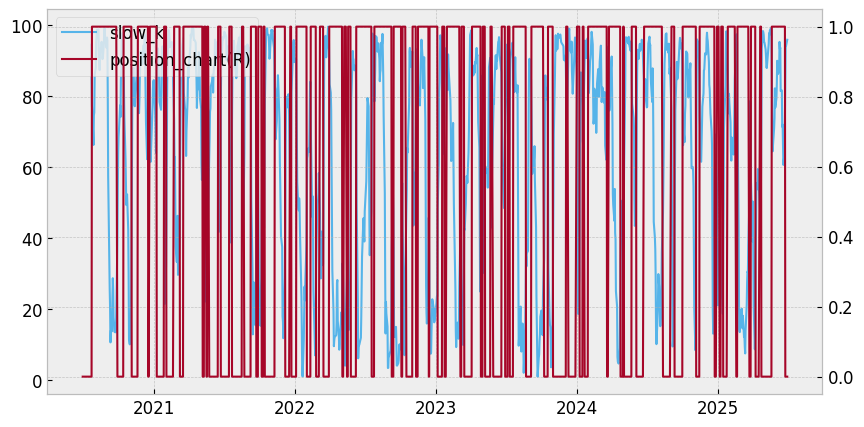

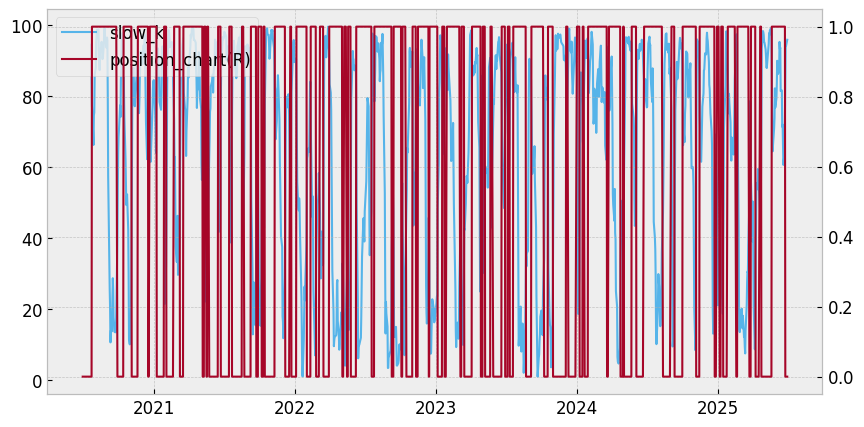

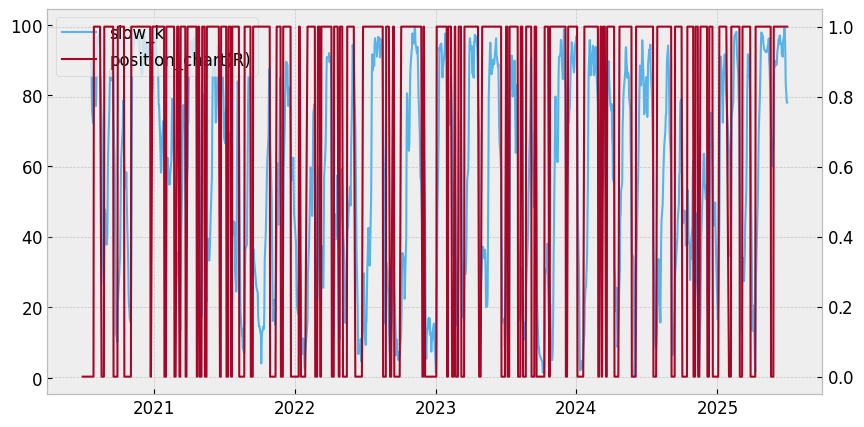

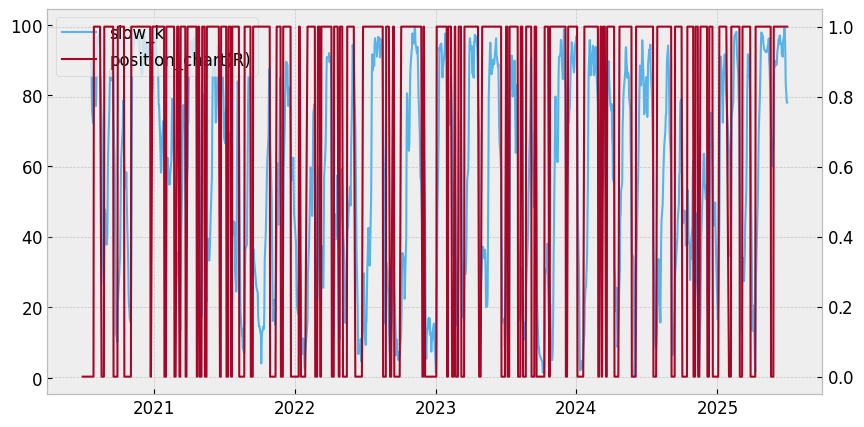

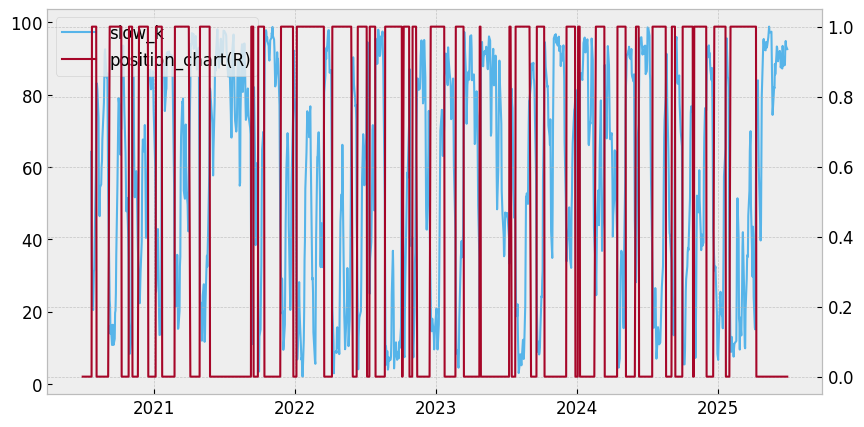

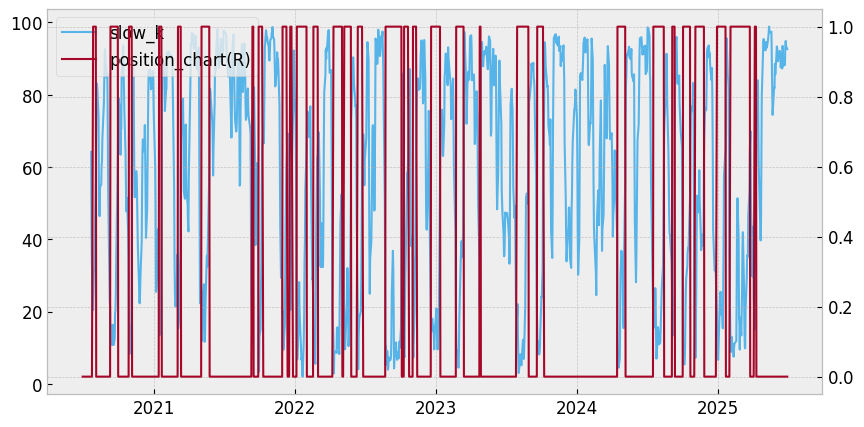

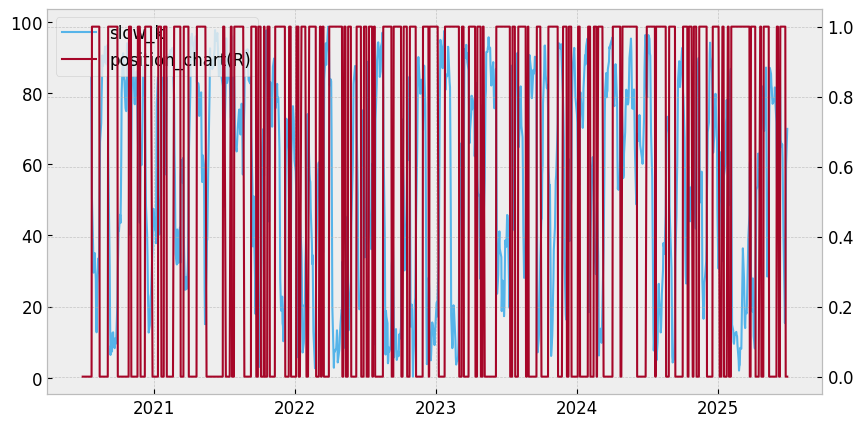

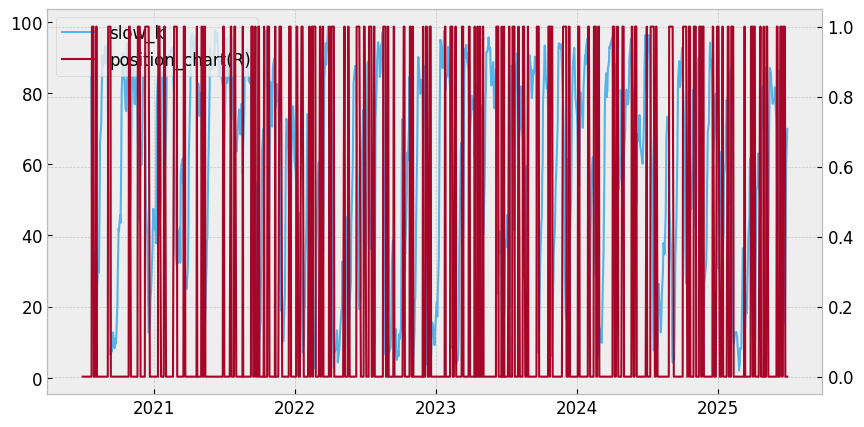

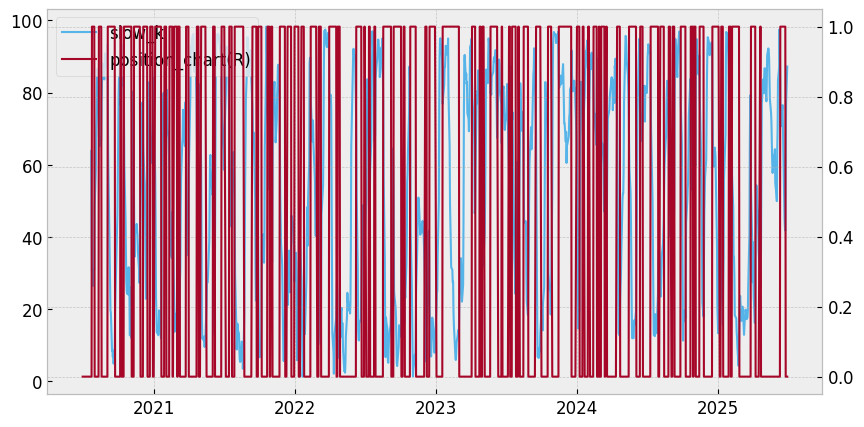

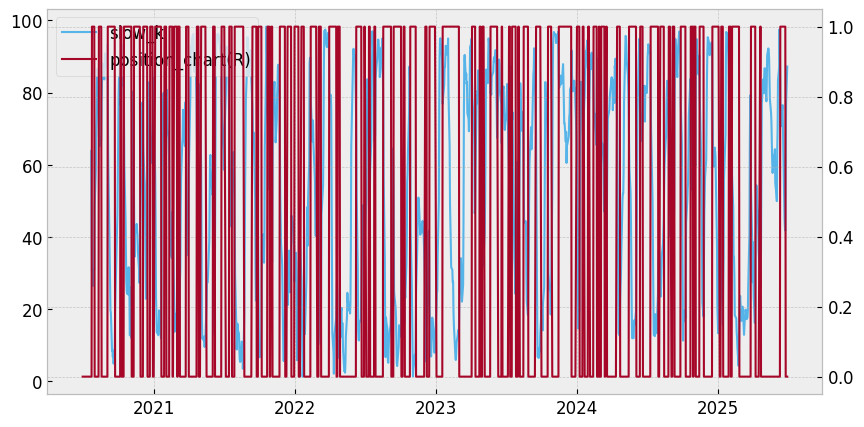

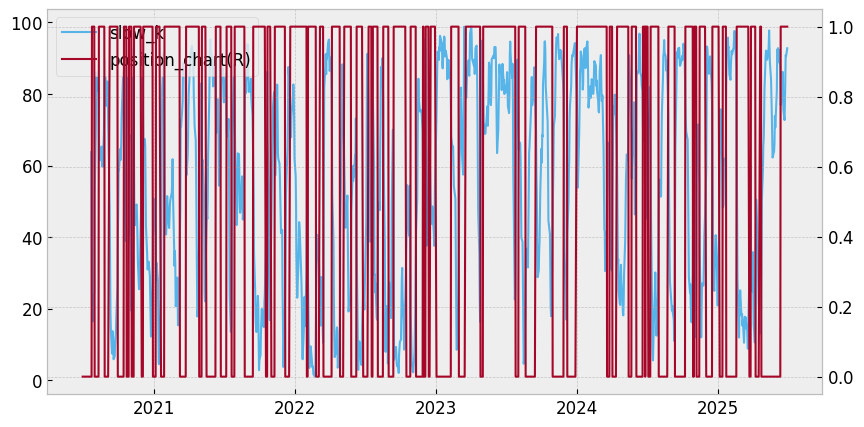

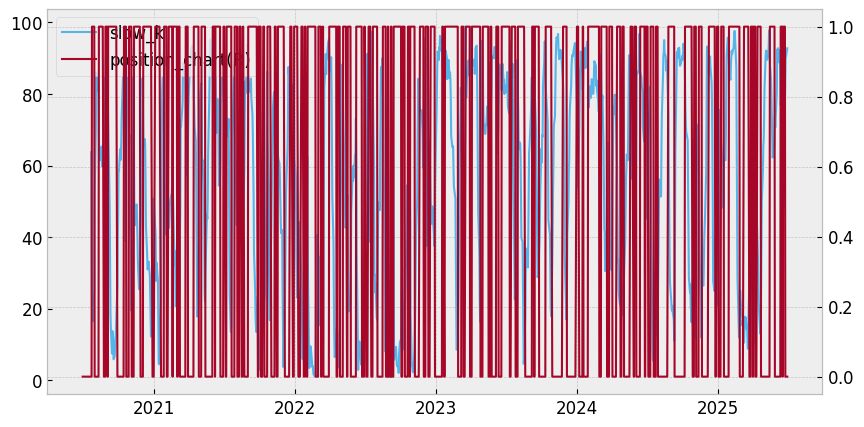

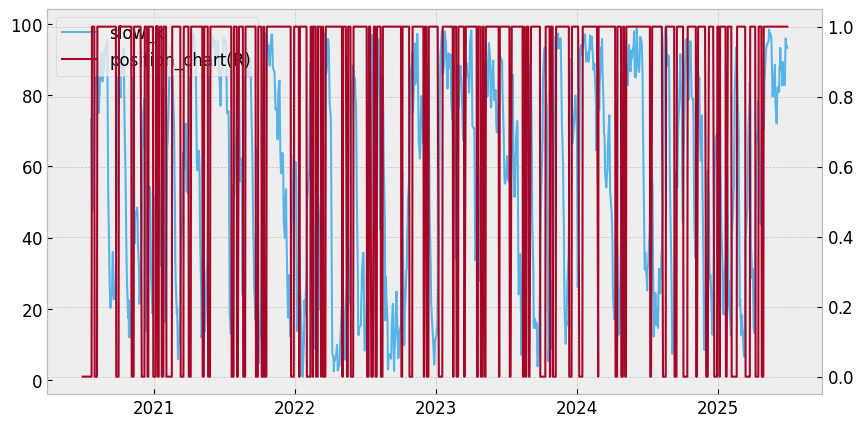

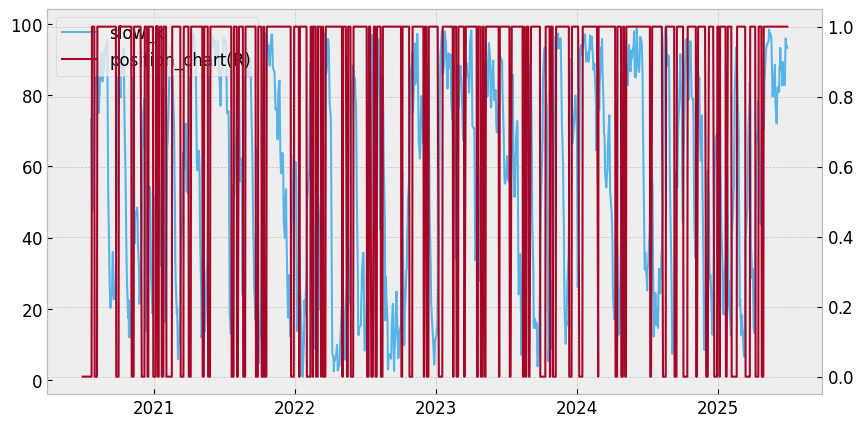

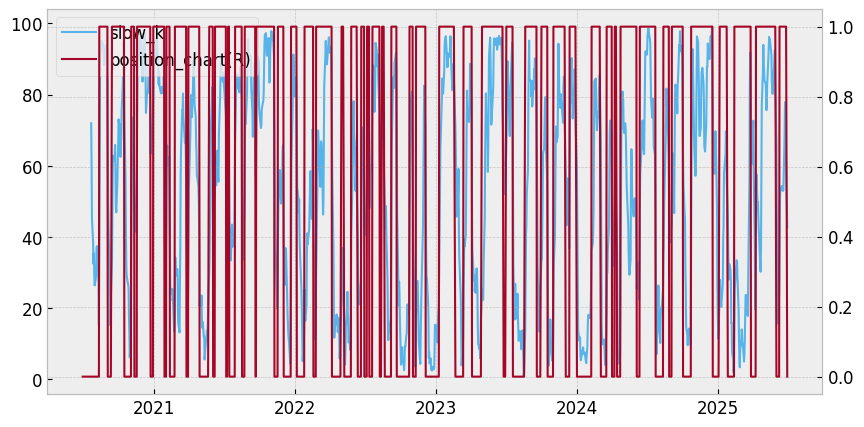

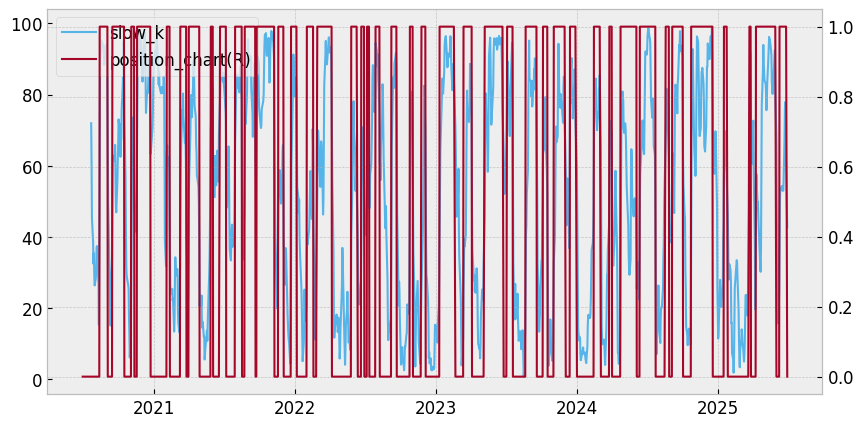

In [21]:
# for
for symbol in symbol_list :
    df_rsi_max_cagr, df_rsi_max_sharpe_ratio, df_macd_max_cagr, df_macd_max_sharpe_ratio, df_sto_max_cagr, df_sto_max_sharpe_ratio \
        = process(symbol, start_date_, end_date_, fee_)

    print(f"##### [{symbol}] 1. RSI #####")
    print(f"   ***** (1) CAGR *****")
    print(df_rsi_max_cagr)
    print(f"   ***** (2) Sharpe Ratio *****")
    print(df_rsi_max_sharpe_ratio)

    print(f"##### [{symbol}] 2. MACD #####")
    print(f"   ***** (1) CAGR *****")
    print(df_macd_max_cagr)
    print(f"   ***** (2) Sharpe Ratio *****")
    print(df_macd_max_sharpe_ratio)

    print(f"##### [{symbol}] 3. Stochastic #####")
    print(f"   ***** (1) CAGR *****")
    print(df_sto_max_cagr)
    print(f"   ***** (2) Sharpe Ratio *****")
    print(df_sto_max_sharpe_ratio)
    print("\n\n")

In [23]:
df_test = fs.get_price('TSLA', start_date=start_date_, end_date=end_date_)

get_rsi_performance(df_test,7,21,81, 0.001)



{'RSI_CAGR': 0.0014000000000000002,
 'RSI_Accumulated return': 0.0072,
 'RSI_Average return': 0.0049,
 'RSI_Benchmark return': 2.4175,
 'RSI_Number of trades': 7.0,
 'RSI_Number of win': 3.0,
 'RSI_Hit ratio': 0.4286,
 'RSI_Investment period': 5.0,
 'RSI_Sharpe ratio': -0.04,
 'RSI_MDD': -0.5666,
 'RSI_Benchmark MDD': -0.7363}